In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
cuda = torch.device('cuda')

In [3]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10

raw_text = """
อย่างสีเหลือง ขี้
มะม่วง แมงโก้
เตา อั้งโล่
มีด อีโต้
ไฮลักซ์ รีโว่
เสื้อใน วาโก้
ตกใจ โอ้โห้ 
นักบอล โรนัลโด้
เยลลี่ ปีโป้
ปั้มน้ำมัน เอสโซ่
แบงก์ กาโม่
ขนม ยูโร่
ของเล่น เลโก้
นายก ฮัลโหลล
<EOS>""".split()

raw_text_list = raw_text.copy()

data = [
    (
        [raw_text[i - j - 1] for j in range(CONTEXT_SIZE)],
        raw_text[i]
    )
    for i in range(CONTEXT_SIZE, len(raw_text))
]

print(data[:3])

[(['ขี้', 'อย่างสีเหลือง'], 'มะม่วง'), (['มะม่วง', 'ขี้'], 'แมงโก้'), (['แมงโก้', 'มะม่วง'], 'เตา')]


In [4]:
vocab = set(raw_text)
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

In [5]:
word_map = {}

for i, word in enumerate(raw_text_list):
    if i == 0:
        continue
    
    if i == len(raw_text_list) - 1 and word != "<EOS>":
        break

    key = ""
    value = ""
    
    if i % 2 == 1:
        key = word
        value = raw_text_list[i-1]
        word_map[key] = value
    else:
        key = word
        word_map[key] = value

print(word_map)

{'ขี้': 'อย่างสีเหลือง', 'มะม่วง': '', 'แมงโก้': 'มะม่วง', 'เตา': '', 'อั้งโล่': 'เตา', 'มีด': '', 'อีโต้': 'มีด', 'ไฮลักซ์': '', 'รีโว่': 'ไฮลักซ์', 'เสื้อใน': '', 'วาโก้': 'เสื้อใน', 'ตกใจ': '', 'โอ้โห้': 'ตกใจ', 'นักบอล': '', 'โรนัลโด้': 'นักบอล', 'เยลลี่': '', 'ปีโป้': 'เยลลี่', 'ปั้มน้ำมัน': '', 'เอสโซ่': 'ปั้มน้ำมัน', 'แบงก์': '', 'กาโม่': 'แบงก์', 'ขนม': '', 'ยูโร่': 'ขนม', 'ของเล่น': '', 'เลโก้': 'ของเล่น', 'นายก': '', 'ฮัลโหลล': 'นายก', '<EOS>': ''}


In [6]:
class NGramLanguageModeler(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128, bias=True)
        self.linear2 = nn.Linear(128, 128, bias=True)
        self.linear3 = nn.Linear(128, vocab_size, bias=True)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out1 = F.relu(self.linear1(embeds))
        out2 = F.relu(self.linear2(out1))
        out3 = self.linear3(out2)
        log_probs = F.log_softmax(out3, dim=1)
        return log_probs

    def make_context_vector(self, context, word_to_ix):
        idxs = [word_to_ix[w] for w in context]
        return torch.tensor(idxs, dtype=torch.long)

In [7]:
losses = []
loss_function = nn.CrossEntropyLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
for epoch in range(1000):
    total_loss = 0
    for context, target in data:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = model.make_context_vector(context, word_to_ix)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def loss_ploting(ax, x, y):
    ax.set_title("losses descending")
    ax.set_ylabel("losses")
    ax.set_xlabel("epochs")
    ax.plot(x, y)

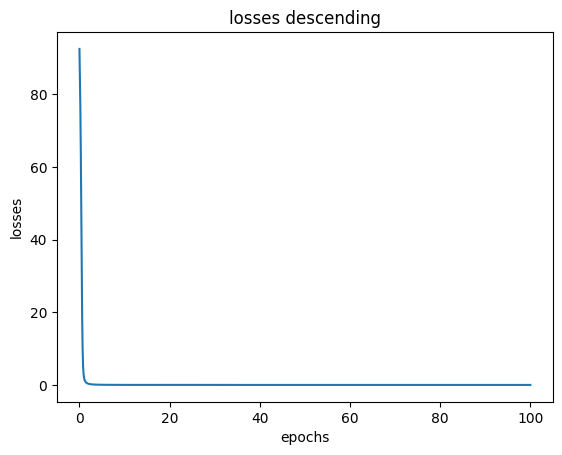

In [11]:
fig, ax = plt.subplots()
loss_ploting(ax, np.linspace(0., 100, len(losses)), losses)

In [12]:
prompts = [
    """อย่างสีเหลือง <EOS>""",
    """มะม่วง <EOS>""",
    """เตา <EOS>""",
    """มีด <EOS>""",
    """ไฮลักซ์ <EOS>""",
    """เสื้อใน <EOS>""",
    """ตกใจ <EOS>""",
    """นักบอล <EOS>""",
    """เยลลี่ <EOS>""",
    """ปั้มน้ำมัน <EOS>""",
    """แบงก์ <EOS>""",
    """ขนม <EOS>""",
    """ของเล่น <EOS>""",
    """นายก <EOS>""",
]

In [13]:
score = 0

for prompt in prompts:
    splited_prompt = prompt.split()
    
    vector_prompt = model.make_context_vector(splited_prompt, word_to_ix)
    
    log_probs = model(vector_prompt)
    
    predicted_index = torch.argmax(log_probs, dim=1).item()
    predicted_word = ix_to_word[predicted_index]
    true_word = word_map[predicted_word]

    is_correct = true_word == prompt.split()[0]
    
    if is_correct:
        score = score + 1
    
    print(prompt.split()[0], predicted_word, is_correct)

print(f"score: {(score/len(prompts))*100}%")

อย่างสีเหลือง ปั้มน้ำมัน False
มะม่วง เลโก้ False
เตา นายก False
มีด อีโต้ True
ไฮลักซ์ รีโว่ True
เสื้อใน วาโก้ True
ตกใจ วาโก้ False
นักบอล เลโก้ False
เยลลี่ ปีโป้ True
ปั้มน้ำมัน เอสโซ่ True
แบงก์ กาโม่ True
ขนม เอสโซ่ False
ของเล่น เลโก้ True
นายก ฮัลโหลล True
score: 57.14285714285714%
